I will base this analysis on the Tempun_in_R analyses, using the tempun package. 

In [2]:
import geopandas as gpd # https://vincent.doba.fr/posts/20210407_install-fiona-on-windows/ & https://geopandas.org/getting_started/install.html Issues with geopandas on windows. The requirements.txt file might be able to install the packages, if not you should look into these geopandas links.
import requests
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from scipy.stats import trapz
import scipy
#import nltk
import json
import tempun
#import sddk
import numpy as np
import pandas as pd
import math
import re

I will now find alle the shipwrecks with an earliest and latest date:

Even though it is called "earliest date" and "latest date" in the dataset, i will use the description "start date" and "end date", so that the terms are the same as in other tempun scripts.

In [3]:
shipwrecks = pd.read_excel("../data/StraussShipwrecks.xlsx")

I will start by cleaning the data a bit. I will do this by finding datapoints with missing data, and look at these. 

In [49]:
Shipwrecks_with_no_start_date = [] #for storring the index of the missing value
for i in range(len(shipwrecks["Earliest date"])): #So that i is the index of the shipwrecks in the missing value
    if math.isnan(shipwrecks["Earliest date"][i]):
        Shipwrecks_with_no_start_date.append(i)

In [50]:
Shipwrecks_with_no_end_date = [] #for storring the index of the missing value
for i in range(len(shipwrecks["Latest date"])): #So that i is the index of the shipwrecks in the missing value
    if math.isnan(shipwrecks["Latest date"][i]):
        Shipwrecks_with_no_end_date.append(i)

In [51]:
Shipwrecks_with_no_dates = [] #check if there is wrecks with no data.
for i in Shipwrecks_with_no_start_date:
    for j in Shipwrecks_with_no_end_date:
        if i == j:
            Shipwrecks_with_no_dates.append(i)

In [52]:
print(len(Shipwrecks_with_no_dates))
print(len(Shipwrecks_with_no_start_date))
print(len(Shipwrecks_with_no_end_date))

66
67
66


From what i have above, all shipwrecks that do not have an latest date, also do not have an earliest date. I can then just subset the data, finding all the whipwrecks that have both datapoints by finding all the datapoints with an earliest date.

In [53]:
Shipwrecks_with_dates_data = shipwrecks.loc[[i for i in range(len(shipwrecks["Earliest date"]))
                                             if i  not in Shipwrecks_with_no_start_date]]

I will now be able to start the analysis:

I will start by generating a list of 1000 random dates between the earliest and latest date, for each shipwreck.

In [54]:
Shipwrecks_with_dates_data["random_dates"] = Shipwrecks_with_dates_data.apply(lambda row: tempun.model_date(
    row["Earliest date"], row["Latest date"], size=1000,), axis=1)

We have now simulated 1000 dates for each shipwreck. The following code now takes a random sample of one date for each shipwreck. With each date assigned a specific date, the function counts the number of inscriptions in each temporal block, in this case every 25 years from 200 bc to 600 AD. By default the function will perform this task 100 times. The output is a list of these 100 random sampels devided into temporal blocks.

Before this, i will need to think about a start and enddate for my analysis:

In [55]:
print(min(Shipwrecks_with_dates_data["Earliest date"]))
print(max(Shipwrecks_with_dates_data["Earliest date"]))
print(min(Shipwrecks_with_dates_data["Latest date"]))
print(max(Shipwrecks_with_dates_data["Latest date"]))


-2500.0
1500.0
-2190.0
1800.0


After looking through the data, i will start in 700 bc and end in 1500 ad

In [56]:
Shipwrecks_complete_simulations = tempun.timeblocks_from_randoms(
    Shipwrecks_with_dates_data, "random_dates", [-700, 1600, 50], random_size=100)

We now have 100 random samples of the number of inscriptions in a given 25-year timeblock, which allows us to create a model. We will create the emperical 90th percentile confidence interval of the number of inscriptions.

In the following we will plot the 90'th percent confidence interval of the number of inscriptions in a given 25 year bloc, this will be the blue part of the graph. The grey part of the graph will show the minimal and maximal number of inscriptions, in a given time-block, from our sampling of the simulation. 

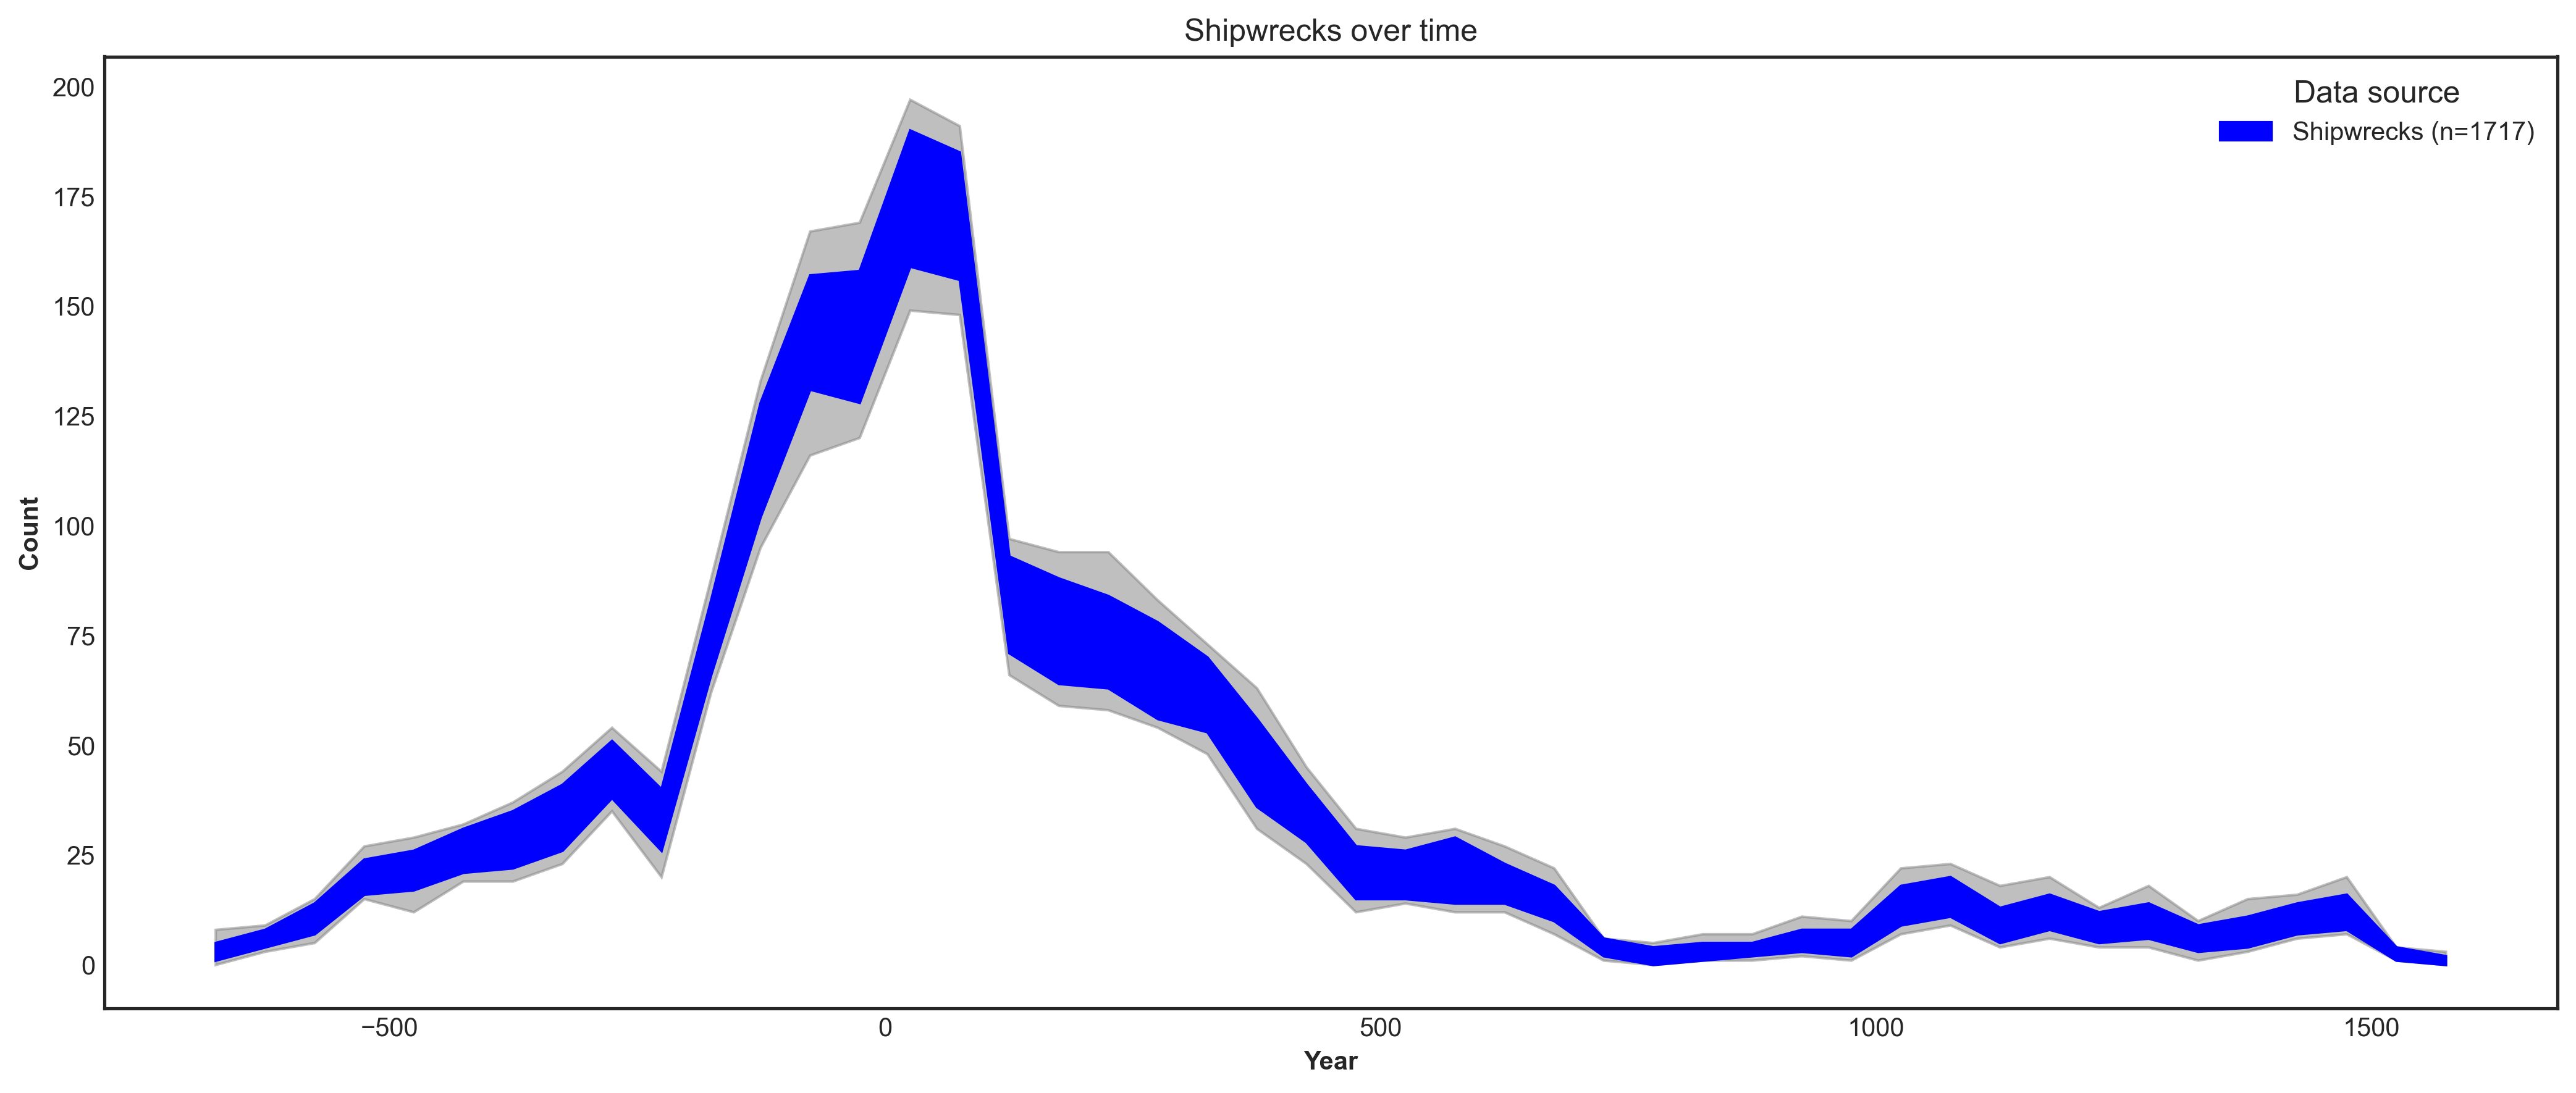

In [57]:
# Figure 1
# plot all the dataset to see the shipwrechs over time

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)

tempun.plot_timeblocks_data(
    Shipwrecks_complete_simulations, ax=ax, color="blue", label=f"Shipwrecks (n={len(Shipwrecks_with_dates_data)})")
    
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Total shipwrecks over time")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

#plt.axvline(x=212, linewidth=0.5, color = 'orange', linestyle='dashed')

#plt.savefig('../output/Fig1_Epi_production_time.png')

### Modelling shipwrecks by where they where they were found

I will try to look at the data by country: I will start by looking at which contries are present in the dataset.

In [58]:
set(Shipwrecks_with_dates_data["Country"])

{'Albania',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Egypt',
 'France',
 'Greece',
 'India',
 'International waters',
 'Israel',
 'Italy',
 'Italy - Sicily',
 'Lebanon',
 'Libya',
 'Malta',
 'Minorca',
 'Montenegro',
 'Romania',
 'Spain',
 'Sudan',
 'Tunisia',
 'Turkey',
 'ZZ-Non-Mediterranean',
 nan}

I will start by creating a list of contries present in the dataset. I will leave NaN out:

In [59]:
List_of_countries = list(set(Shipwrecks_with_dates_data["Country"]))
List_of_countries

['Lebanon',
 'Croatia',
 'India',
 'Cyprus',
 'Spain',
 'Malta',
 'International waters',
 'Tunisia',
 'Turkey',
 'Bulgaria',
 'Minorca',
 'Albania',
 'Egypt',
 'Romania',
 'Montenegro',
 'Israel',
 'Libya',
 nan,
 'Sudan',
 'Italy - Sicily',
 'Italy',
 'France',
 'ZZ-Non-Mediterranean',
 'Greece']

I will now get rid of Nan:

In [60]:
List_of_countries = [country for country in List_of_countries if type(country) == str] #makes sure that all elements are strings
List_of_countries

['Lebanon',
 'Croatia',
 'India',
 'Cyprus',
 'Spain',
 'Malta',
 'International waters',
 'Tunisia',
 'Turkey',
 'Bulgaria',
 'Minorca',
 'Albania',
 'Egypt',
 'Romania',
 'Montenegro',
 'Israel',
 'Libya',
 'Sudan',
 'Italy - Sicily',
 'Italy',
 'France',
 'ZZ-Non-Mediterranean',
 'Greece']

I will now count how many shipwrecks are from each country:

In [61]:
List_of_contries_numbers = []
for country in List_of_countries:
    Number_of_observations = len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Country"] == country])
    List_of_contries_numbers.append((country, Number_of_observations))
List_of_contries_numbers

[('Lebanon', 5),
 ('Croatia', 63),
 ('India', 1),
 ('Cyprus', 13),
 ('Spain', 29),
 ('Malta', 1),
 ('International waters', 9),
 ('Tunisia', 2),
 ('Turkey', 60),
 ('Bulgaria', 18),
 ('Minorca', 1),
 ('Albania', 11),
 ('Egypt', 4),
 ('Romania', 1),
 ('Montenegro', 2),
 ('Israel', 54),
 ('Libya', 6),
 ('Sudan', 1),
 ('Italy - Sicily', 1),
 ('Italy', 239),
 ('France', 207),
 ('ZZ-Non-Mediterranean', 68),
 ('Greece', 87)]

I will now examine how many shipwrecks where given the "nan" country discription.

In [62]:
Number_of_shipwrecks_with_country = sum([number[1] for number in List_of_contries_numbers])

len(shipwrecks) - Number_of_shipwrecks_with_country

901

There are 901 shipwrecks without a country connected to them, this is problematic as it is almost half the dataset.

I will look at the dataset anyway. I will leave out the "non-Mediterranean" and any country with less than 25 oberservation.

In [63]:
#Select the ones with more than 30 observations and not non-mediterranean.
Countries_to_model = [country for country in List_of_contries_numbers if country[1] > 25
                      and country[0] != 'ZZ-Non-Mediterranean']
Countries_to_model

[('Croatia', 63),
 ('Spain', 29),
 ('Turkey', 60),
 ('Israel', 54),
 ('Italy', 239),
 ('France', 207),
 ('Greece', 87)]

I can now model this:

In [64]:
#I will start by completing simulation for each country
country_complete_simpulations = [] 
for country in Countries_to_model:
    country_df = Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Country"] == country[0]]
    country_simulation = tempun.timeblocks_from_randoms(
        country_df, "random_dates", [-700, 1600, 50], random_size=100)
    country_complete_simpulations.append((country[0], country_simulation, country[1]))

I can now plot this over time using the tempun package.

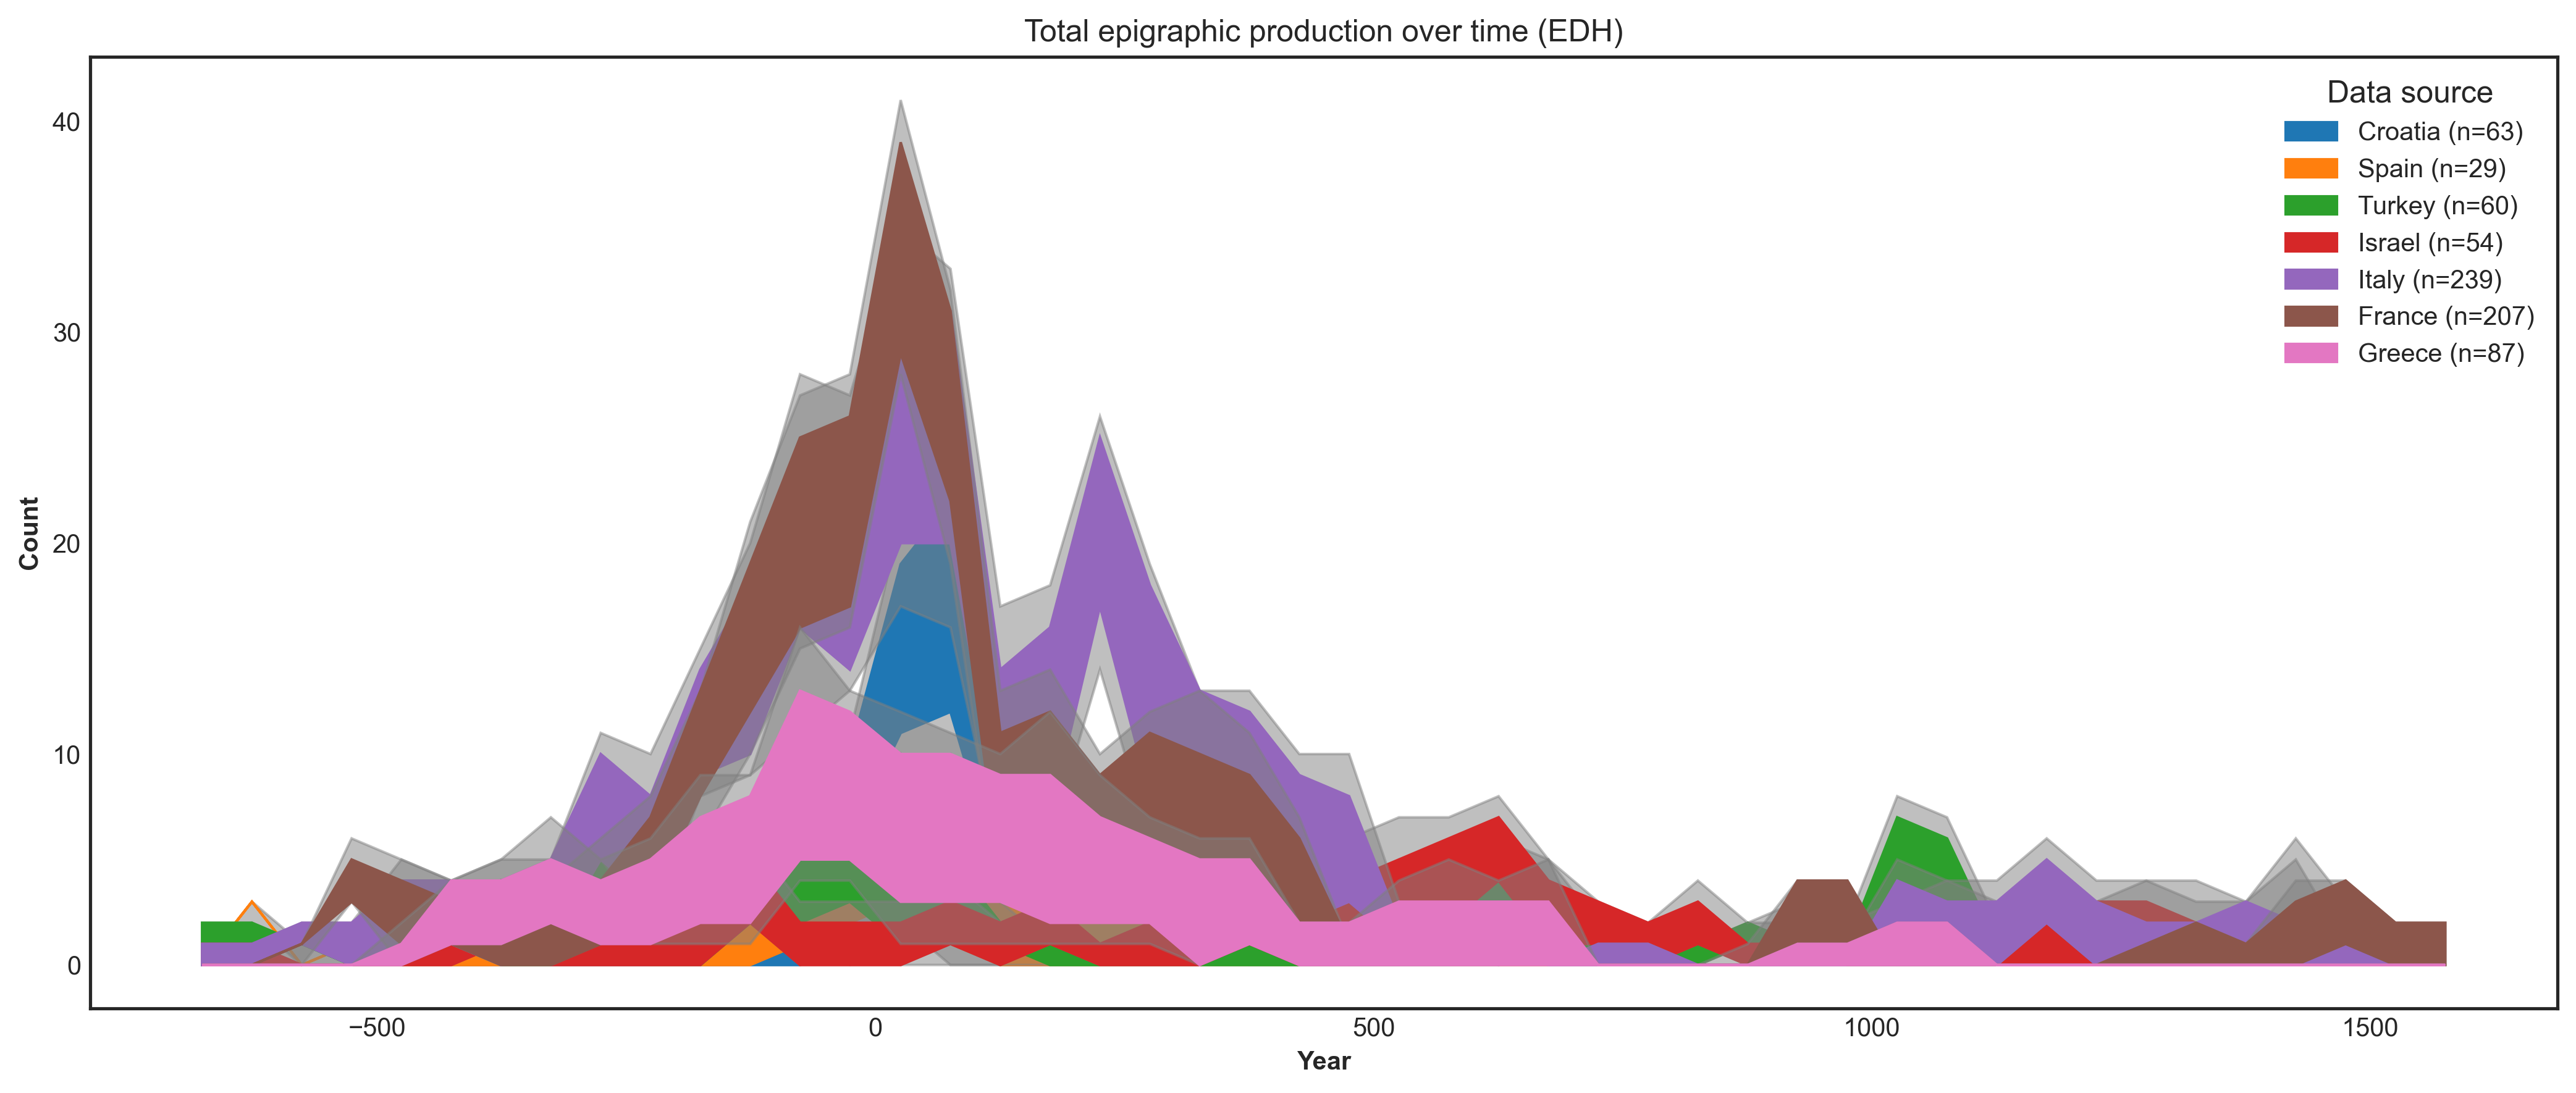

In [65]:
# Figure 2 

plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)

for country, color in zip(country_complete_simpulations, tab_colors_list[:len(Countries_to_model)]):
    tempun.plot_timeblocks_data(
        country[1], ax=ax, color=color, 
            label=f"{country[0]} (n={country[2]})")
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Shipwrecks by where they were found")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')

#plt.axvline(x=212, linewidth=0.5, color = 'orange', linestyle='dashed')

#fig.suptitle(f'Comparison of epigraphic production over time', fontsize=16,fontweight="bold")
#plt.savefig('../output/Fig1_Epi_production_time.png')

### Modelling the by country of destination

I will start by cleaning the data, getting rid of datapoints where the country of destination is unknown. I will start by checking how the destinations are formatted. 

In [66]:
set(Shipwrecks_with_dates_data["Place of destination"])

{'?',
 'Adriatic/ further east?',
 'Aegean',
 'Aegean?',
 'Aegean? Rome?',
 'Alexandria',
 'Anhialo',
 'Apollonia',
 'Aquileia ?',
 'Argolic Gulf',
 'Bizone',
 'Black Sea',
 'Black Sea?',
 'Brega, for trans shipment (?)',
 'Caesarea',
 'Caesarea Maritima',
 'Cassis',
 'Cavalaire, South of France',
 'Claros, Turkey?',
 'Constantinople',
 'Constantinople?',
 'Crete',
 'Cyprus/ Levant',
 'Cyprus/Levant',
 'Cyprus/Levant?',
 'Cyprus?',
 'Egypt?',
 'France',
 'France, Spain?',
 'France/Spain?',
 'France?',
 'French coast, Pyrenées',
 'Gaul, Spain??',
 'Gaul?',
 'Ikos',
 'India',
 'India?',
 'Inland France?',
 'Israel, Egypt?',
 'Italy',
 'Italy?',
 'Levant',
 'Marseilles?',
 'Marseillles',
 'Mesembria',
 'Montpellier?',
 'North Africa',
 'North Africa?',
 'Northern  Italy',
 'Northern Italy',
 'Odessos',
 'Palestine',
 'Pergamum?',
 'Pisa',
 'Rome',
 'Rome/France/            Spain?',
 'Rome/France/ Spain?',
 'Rome?',
 'Sicily',
 'Sicily/North Africa?',
 'Sicily/Rome?',
 'Sicily?',
 'South o

I will start by clearning out the datapoints with detinations "nan" or "?"

In [67]:
#I will start by cleaning "nan"

Destinations = list(set(Shipwrecks_with_dates_data["Place of destination"]))

List_of_destinations = [country for country in Destinations if type(country) == str] #removing the Nan

List_of_destinations = [country for country in List_of_destinations if country != "?"] # removing "?"

List_of_destinations

['Marseillles',
 'Cyprus?',
 'South west France? Inland France?',
 'France?',
 'Egypt?',
 'Gaul, Spain??',
 'Northern  Italy',
 'Rome',
 'Rome/France/ Spain?',
 'Adriatic/ further east?',
 'Sicily/Rome?',
 'Aegean? Rome?',
 'South of France',
 'Aegean?',
 'Cyprus/Levant?',
 'Cyprus/Levant',
 'India?',
 'Aegean',
 'India',
 'Montpellier?',
 'Southern Levant or Cyprus',
 'Anhialo',
 'Alexandria',
 'North Africa?',
 'Bizone',
 'Constantinople?',
 'North Africa',
 'Cavalaire, South of France',
 'France, Spain?',
 'Pisa',
 'Crete',
 'Cyprus/ Levant',
 'Sicily/North Africa?',
 'Brega, for trans shipment (?)',
 'Argolic Gulf',
 'Sicily?',
 'Caesarea Maritima',
 'Sicily',
 'Mesembria',
 'Aquileia ?',
 'Caesarea',
 'France/Spain?',
 'Levant',
 'Inland France?',
 'Spain/ France?',
 'Rome/France/            Spain?',
 'Black Sea',
 'Claros, Turkey?',
 'Cassis',
 'Pergamum?',
 'Apollonia',
 'Black Sea?',
 'Odessos',
 'Constantinople',
 'Israel, Egypt?',
 'Ikos',
 'Italy?',
 'Gaul?',
 'Italy',
 'Pal

It is now clear that some of theese places are infact the same ones, but some are with quite a bit of uncertainty. I will start by stripping away "?" and "/" and " ", and Sorting into tubles with the "same" destinations. 

In [68]:
Stripped_destinations = []
for destination in List_of_destinations:
    destination_lower = destination.lower()
    Stripped_destinations.append((list(set(re.findall("[a-z]+",destination_lower))), destination)) 
Stripped_destinations

[(['marseillles'], 'Marseillles'),
 (['cyprus'], 'Cyprus?'),
 (['france', 'west', 'inland', 'south'], 'South west France? Inland France?'),
 (['france'], 'France?'),
 (['egypt'], 'Egypt?'),
 (['spain', 'gaul'], 'Gaul, Spain??'),
 (['northern', 'italy'], 'Northern  Italy'),
 (['rome'], 'Rome'),
 (['france', 'spain', 'rome'], 'Rome/France/ Spain?'),
 (['east', 'adriatic', 'further'], 'Adriatic/ further east?'),
 (['sicily', 'rome'], 'Sicily/Rome?'),
 (['aegean', 'rome'], 'Aegean? Rome?'),
 (['france', 'of', 'south'], 'South of France'),
 (['aegean'], 'Aegean?'),
 (['levant', 'cyprus'], 'Cyprus/Levant?'),
 (['levant', 'cyprus'], 'Cyprus/Levant'),
 (['india'], 'India?'),
 (['aegean'], 'Aegean'),
 (['india'], 'India'),
 (['montpellier'], 'Montpellier?'),
 (['southern', 'levant', 'cyprus', 'or'], 'Southern Levant or Cyprus'),
 (['anhialo'], 'Anhialo'),
 (['alexandria'], 'Alexandria'),
 (['africa', 'north'], 'North Africa?'),
 (['bizone'], 'Bizone'),
 (['constantinople'], 'Constantinople?'),


From the stripped expressions, it is easy to see that some of these destinations are essentially the same, i will start by grouping the ones that are the samme apart from a different word order, or a "?", " " og "/".

In [69]:
unique_regex = []

for regex, destination in Stripped_destinations: #finding unique regex
    if regex not in unique_regex:
        unique_regex.append((regex))
        
unique_regex = [(regex, []) for regex in unique_regex] #Making a list of the different regex

for regex, destination in Stripped_destinations: #grouping unique regex. 
    for unique in unique_regex:
        if regex == unique[0]:
            unique[1].append(destination)
unique_regex

[(['marseillles'], ['Marseillles']),
 (['cyprus'], ['Cyprus?']),
 (['france', 'west', 'inland', 'south'],
  ['South west France? Inland France?']),
 (['france'], ['France?', 'France']),
 (['egypt'], ['Egypt?']),
 (['spain', 'gaul'], ['Gaul, Spain??']),
 (['northern', 'italy'],
  ['Northern  Italy', 'Northern Italy', 'northern Italy']),
 (['rome'], ['Rome', 'Rome?']),
 (['france', 'spain', 'rome'],
  ['Rome/France/ Spain?', 'Rome/France/            Spain?']),
 (['east', 'adriatic', 'further'], ['Adriatic/ further east?']),
 (['sicily', 'rome'], ['Sicily/Rome?']),
 (['aegean', 'rome'], ['Aegean? Rome?']),
 (['france', 'of', 'south'], ['South of France']),
 (['aegean'], ['Aegean?', 'Aegean']),
 (['levant', 'cyprus'], ['Cyprus/Levant?', 'Cyprus/Levant', 'Cyprus/ Levant']),
 (['india'], ['India?', 'India']),
 (['montpellier'], ['Montpellier?']),
 (['southern', 'levant', 'cyprus', 'or'], ['Southern Levant or Cyprus']),
 (['anhialo'], ['Anhialo']),
 (['alexandria'], ['Alexandria']),
 (['afric

I will count how many are of the different types:

In [70]:
different_regex_numbers = []
for regex in unique_regex:
    number = 0
    for destination in regex[1]:
        number += len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Place of destination"] == destination])
    print(regex[0])
    print(number)

['marseillles']
1
['cyprus']
1
['france', 'west', 'inland', 'south']
3
['france']
12
['egypt']
2
['spain', 'gaul']
1
['northern', 'italy']
19
['rome']
41
['france', 'spain', 'rome']
3
['east', 'adriatic', 'further']
1
['sicily', 'rome']
5
['aegean', 'rome']
1
['france', 'of', 'south']
1
['aegean']
4
['levant', 'cyprus']
3
['india']
3
['montpellier']
1
['southern', 'levant', 'cyprus', 'or']
1
['anhialo']
1
['alexandria']
4
['africa', 'north']
4
['bizone']
1
['constantinople']
2
['france', 'of', 'cavalaire', 'south']
1
['france', 'spain']
8
['pisa']
2
['crete']
1
['africa', 'sicily', 'north']
1
['for', 'brega', 'shipment', 'trans']
1
['argolic', 'gulf']
1
['sicily']
4
['maritima', 'caesarea']
1
['mesembria']
3
['aquileia']
1
['caesarea']
1
['levant']
1
['france', 'inland']
1
['sea', 'black']
3
['claros', 'turkey']
1
['cassis']
1
['pergamum']
1
['apollonia']
1
['odessos']
1
['egypt', 'israel']
1
['ikos']
1
['italy']
15
['gaul']
1
['palestine']
1
['marseilles']
1
['in', 'palace', 'the', 'a

In [71]:
number = 0
for destination in List_of_destinations:
    number += len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Place of destination"] == destination])
number

173

In total there are only 173 datapoints with a destination attached

Looking into this, for a lot of the destinations, there are so few datapoints, that it doesn't really make sence to analyse them. I will extract the datapoints related to modern france and Italy. 

In [72]:
list_of_french_regex = ["france", "french", "marseilles", "montpellier", "gaul", "cassis"] # making a list of words related to france
destination_related_to_france = []
for destination in unique_regex:
    for word in list_of_french_regex:
        if word in destination[0]:
            destination_related_to_france.append(destination)
            break
destination_related_to_france

[(['france', 'west', 'inland', 'south'],
  ['South west France? Inland France?']),
 (['france'], ['France?', 'France']),
 (['spain', 'gaul'], ['Gaul, Spain??']),
 (['france', 'spain', 'rome'],
  ['Rome/France/ Spain?', 'Rome/France/            Spain?']),
 (['france', 'of', 'south'], ['South of France']),
 (['montpellier'], ['Montpellier?']),
 (['france', 'of', 'cavalaire', 'south'], ['Cavalaire, South of France']),
 (['france', 'spain'], ['France, Spain?', 'France/Spain?', 'Spain/ France?']),
 (['france', 'inland'], ['Inland France?']),
 (['cassis'], ['Cassis']),
 (['gaul'], ['Gaul?']),
 (['marseilles'], ['Marseilles?']),
 (['french', 'pyren', 'coast', 'es'], ['French coast, Pyrenées'])]

I will now look at how many destinations are related to france.

In [73]:
number = 0
for regex in destination_related_to_france:
    for destination in regex[1]:
        number += len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Place of destination"] == destination])
number

35

So there are 66 datapoints related to modern day france, i will now look into the destinations related to modern day italy:

In [74]:
list_of_italian_regex = ["italy", "italian", "rome", "pisa", "sicily"] # making a list of words related to france
destination_related_to_italy = []
for destination in  unique_regex:
    for word in list_of_italian_regex:
        if word in destination[0]:
            destination_related_to_italy.append(destination)
            break
destination_related_to_italy

[(['northern', 'italy'],
  ['Northern  Italy', 'Northern Italy', 'northern Italy']),
 (['rome'], ['Rome', 'Rome?']),
 (['france', 'spain', 'rome'],
  ['Rome/France/ Spain?', 'Rome/France/            Spain?']),
 (['sicily', 'rome'], ['Sicily/Rome?']),
 (['aegean', 'rome'], ['Aegean? Rome?']),
 (['pisa'], ['Pisa']),
 (['africa', 'sicily', 'north'], ['Sicily/North Africa?']),
 (['sicily'], ['Sicily?', 'Sicily']),
 (['italy'], ['Italy?', 'Italy'])]

I will count these observations!

In [75]:
number = 0
for regex in destination_related_to_italy:
    for destination in regex[1]:
        number += len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Place of destination"] == destination])
number

91

In [76]:
list_of_regex_italy = []
for regex in destination_related_to_italy:
    for destination in regex[1]:
       list_of_regex_italy.append(destination)
list_of_regex_italy

list_of_regex_france = []
for regex in destination_related_to_france:
    for destination in regex[1]:
       list_of_regex_france.append(destination)
list_of_regex_france

['South west France? Inland France?',
 'France?',
 'France',
 'Gaul, Spain??',
 'Rome/France/ Spain?',
 'Rome/France/            Spain?',
 'South of France',
 'Montpellier?',
 'Cavalaire, South of France',
 'France, Spain?',
 'France/Spain?',
 'Spain/ France?',
 'Inland France?',
 'Cassis',
 'Gaul?',
 'Marseilles?',
 'French coast, Pyrenées']

In [77]:
subsetting = [destination in list_of_regex_italy for destination in Shipwrecks_with_dates_data["Place of destination"]]
len(Shipwrecks_with_dates_data[subsetting])

91

So i have 91 datapoints with a destination related to modern day italy.

I will now try to model the countries where the destination is related to italy and france as done before. 

In [78]:
#I will need a subset of the data, with the datapoints relatied to italy
#The following line of code will be a list of "true" or "False" related to wrether or not the datapoint is 
#related to italy
subsetting_italy  = [destination in list_of_regex_italy for destination in Shipwrecks_with_dates_data["Place of destination"]]
#I will start by completing simulation for each france and italy
Italy_complete_simpulations_ = []
italy_df = Shipwrecks_with_dates_data[subsetting_italy]
italy_simulation = tempun.timeblocks_from_randoms(
    italy_df, "random_dates", [-700, 1600, 50], random_size=100)

#I will do the same for france
subsetting_france  = [destination in list_of_regex_france for destination in Shipwrecks_with_dates_data["Place of destination"]]
#I will start by completing simulation for each france and italy
france_complete_simpulations_ = []
france_df = Shipwrecks_with_dates_data[subsetting_france]
france_simulation = tempun.timeblocks_from_randoms(
    france_df, "random_dates", [-700, 1600, 50], random_size=100)

I will now plot the italy and france destination data.

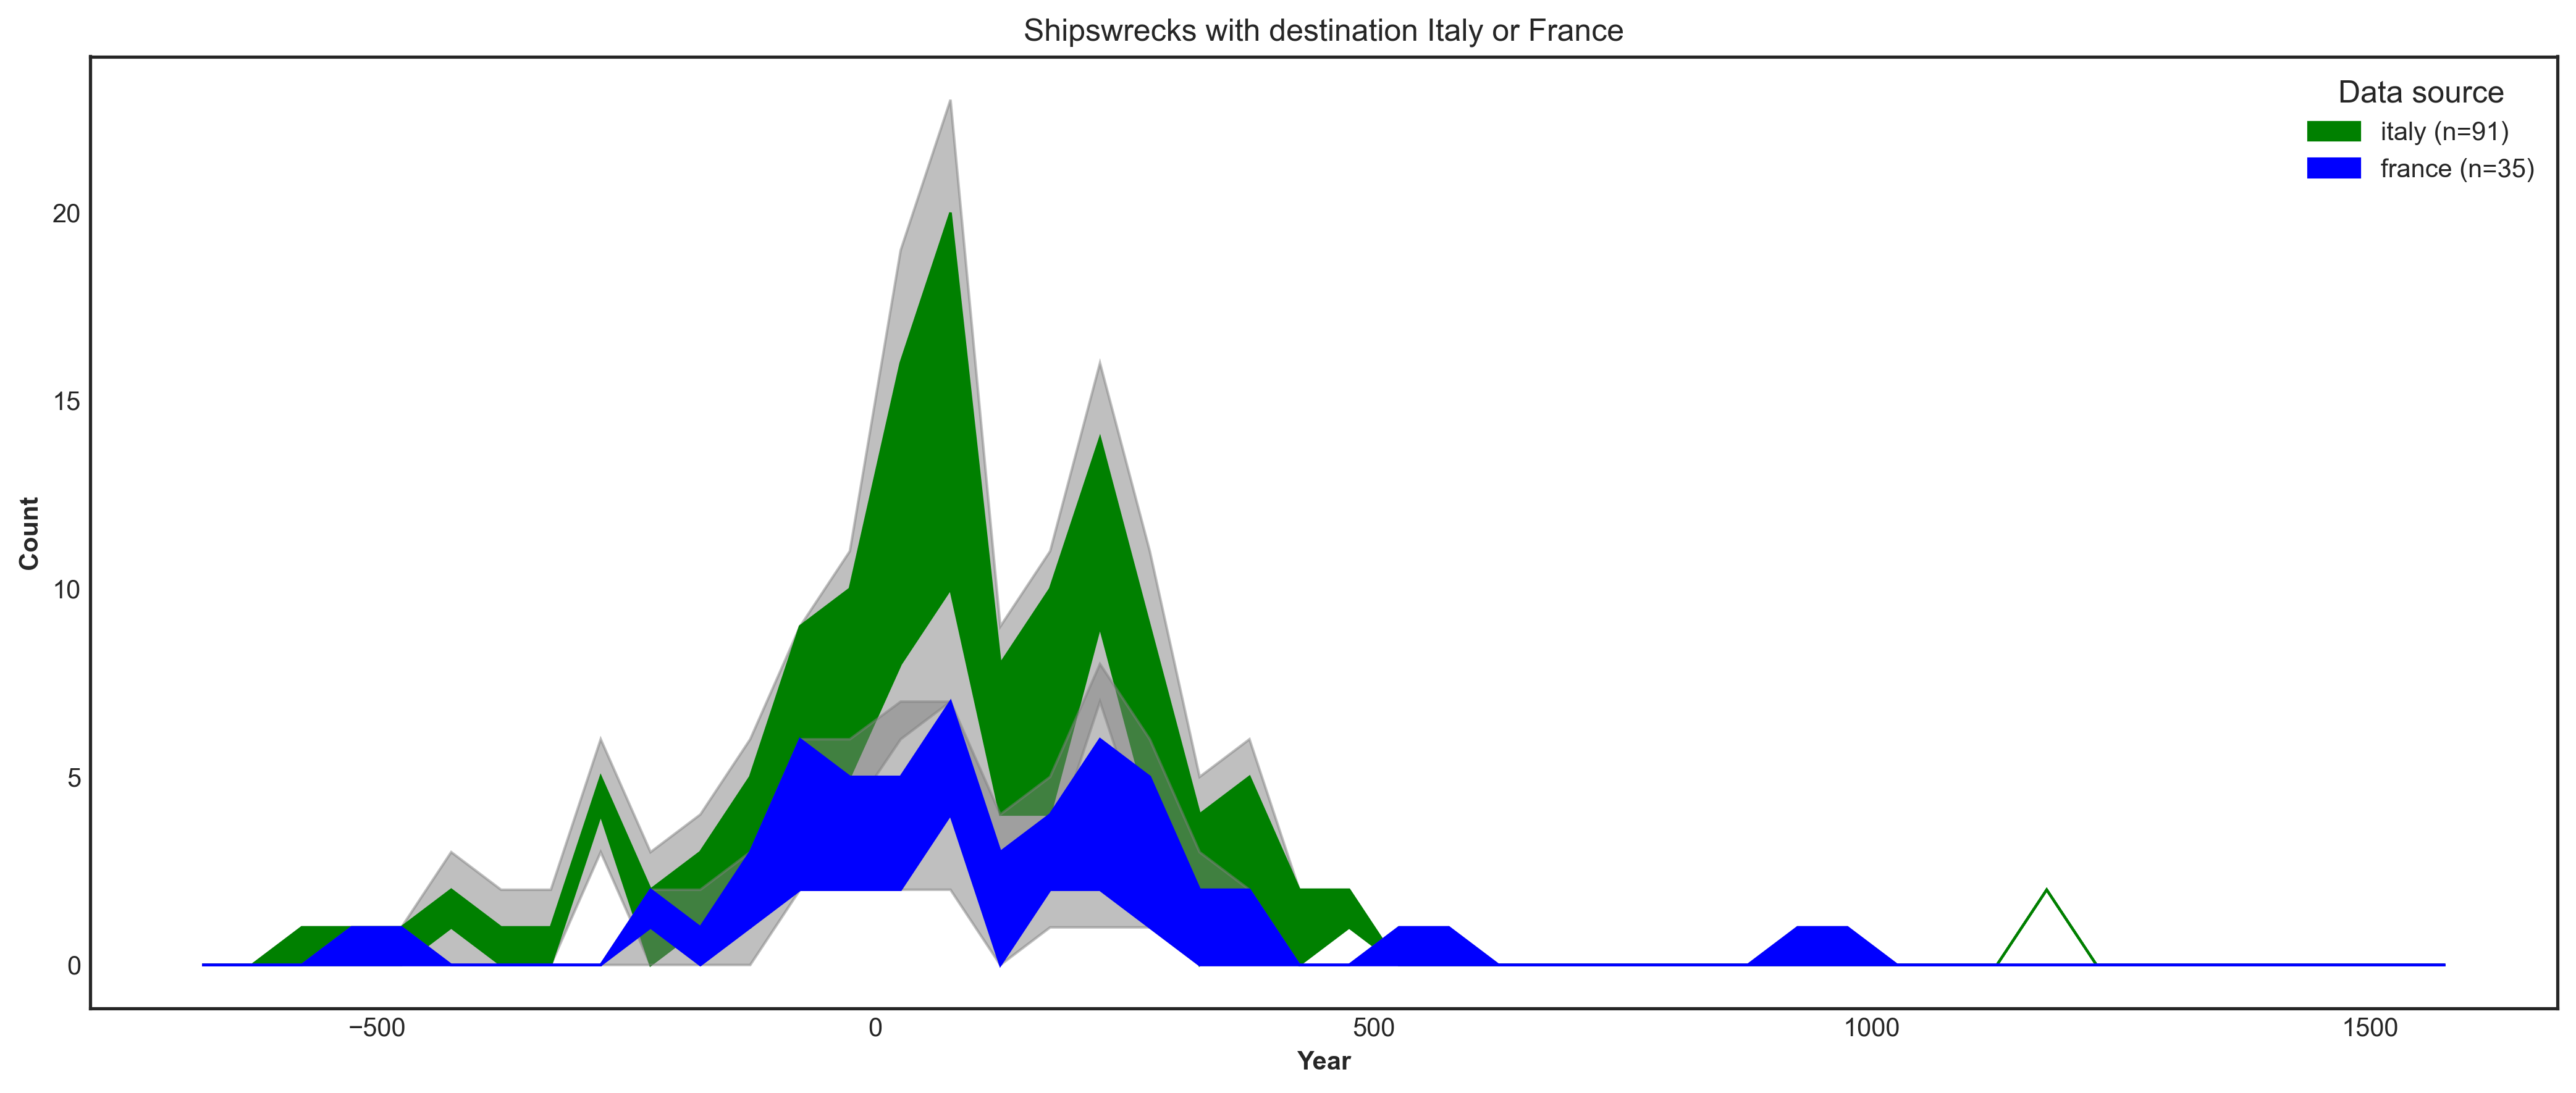

In [92]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)


tempun.plot_timeblocks_data(
    italy_simulation, ax=ax, color="green", label=f"italy (n={len(italy_df)})")

tempun.plot_timeblocks_data(
    france_simulation, ax=ax, color="blue", label=f"france (n={len(france_df)})")

    
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Shipswrecks with destination Italy or France")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')


For both France and italy, because of the very few datapoints, the graph is very wide, implying that the analysis is very insecure.

## Modelling the origins of ships

In [81]:
#I will start by cleaning "nan"

origin = list(set(Shipwrecks_with_dates_data["Place of origin"]))

List_of_origins = [country for country in origin if type(country) == str] #removing the Nan

List_of_origins = [country for country in List_of_origins if country != "?"] # removing "?"

List_of_origins

['Aegean? Tripolitania? Italy',
 'Cos?',
 'Greece?',
 'Aegean.',
 'Cos',
 'Etruria',
 'Cadiz?',
 'Teos, Naxos, Rome',
 'Aegean?',
 'Aegean',
 'Assos',
 'Herakleia Pontica',
 'Thessaly, Proconnesus',
 'Cyprus',
 'Crimea',
 'Cartagena, Spain',
 'Near East',
 'Eastern Crete',
 'Thasos',
 'Campania',
 'Lusitania',
 'Spain, Aegean, Adriatic',
 'Attica? Euboea?',
 'Aegean/Africa',
 'Marseille',
 'Greece? Southern Italy?',
 'Eastern Mediterranean',
 'Pamphylia',
 'Aegean, Italy',
 'Carthage? Aegean?',
 'Syria/Palestine via Ugarit',
 'Tripolitania (?)',
 'Asia Minor',
 'Palestine/Rhodes',
 'Neapolis (Nabeul) North Africa',
 'Athens via Delos?',
 'Cos, Crete, Italy',
 'Egypt and Crete via Campania',
 'El Rosa, Calella, Spain',
 'Luna?',
 'North Africa ?',
 'Islamic Maghreb?',
 'Egypt? W. Med.?',
 'Phoenicia',
 'Elba',
 'Sardinia',
 'Asia',
 'Adriatic via Africa, Spain, France',
 'Egypt? Luna?',
 'Llobregat, Spain',
 'Cosa?',
 'Aegean/N. Africa/Propontis',
 'Barcino/ Baetulo, Spain',
 'Cos, Rhod

In [82]:
number = 0
for origin in List_of_origins:
    number += len(Shipwrecks_with_dates_data[Shipwrecks_with_dates_data["Place of origin"] == origin])
number

310

I have a lot more datapoints to work with here, also clearly the arceologists seem to have been more sure of the "place of origin" than the "place of destination".

I now have a problem. For a lot of the datapoints the place of origin is described as as "Italy via Crete and Rhodes". Is the place of origin then italy, Crete or Rhodos? Well this depends on what we want to model. In the following we would like to model how many ships went down, relative to the origin of the ship over time. For this reason i will count a ship originating at "Italy via Crete and Rhodes" as originating from both crete, Rhodos and Italy. I will start by cleaning the data for "?" and spaces.

In [83]:
Stripped_origins = []
for origin in List_of_origins:
    origin_lower = origin.lower()
    Stripped_origins.append((list(set(re.findall("[a-z]+",origin_lower))), origin)) 
Stripped_origins

[(['aegean', 'italy', 'tripolitania'], 'Aegean? Tripolitania? Italy'),
 (['cos'], 'Cos?'),
 (['greece'], 'Greece?'),
 (['aegean'], 'Aegean.'),
 (['cos'], 'Cos'),
 (['etruria'], 'Etruria'),
 (['cadiz'], 'Cadiz?'),
 (['rome', 'teos', 'naxos'], 'Teos, Naxos, Rome'),
 (['aegean'], 'Aegean?'),
 (['aegean'], 'Aegean'),
 (['assos'], 'Assos'),
 (['pontica', 'herakleia'], 'Herakleia Pontica'),
 (['thessaly', 'proconnesus'], 'Thessaly, Proconnesus'),
 (['cyprus'], 'Cyprus'),
 (['crimea'], 'Crimea'),
 (['cartagena', 'spain'], 'Cartagena, Spain'),
 (['east', 'near'], 'Near East'),
 (['crete', 'eastern'], 'Eastern Crete'),
 (['thasos'], 'Thasos'),
 (['campania'], 'Campania'),
 (['lusitania'], 'Lusitania'),
 (['adriatic', 'spain', 'aegean'], 'Spain, Aegean, Adriatic'),
 (['attica', 'euboea'], 'Attica? Euboea?'),
 (['africa', 'aegean'], 'Aegean/Africa'),
 (['marseille'], 'Marseille'),
 (['southern', 'italy', 'greece'], 'Greece? Southern Italy?'),
 (['eastern', 'mediterranean'], 'Eastern Mediterranean

In [84]:
#I will start by making a list of countries related to greece.
List_greek_origin = ["thessaly", "euboea", "thasos", "pergamum", 
                     "aegean", "rhodes", "cos", "corinth", "crete", 
                     "athens", "greece", "peparethos", "carystos",
                     "euboea", "peparethos", "delos", "teos", "naxos"
                    "chios", "euboea","ganos", "assos", "paros", "thasos", "samos"]
#I will now find the datapoints related to greece:
data_related_to_greece = []
for country in Stripped_origins:
    for greece in List_greek_origin:
        if greece in country[0]:
            data_related_to_greece.append(country)
            break #to make sure that an element is only added once.
data_related_to_greece

[(['aegean', 'italy', 'tripolitania'], 'Aegean? Tripolitania? Italy'),
 (['cos'], 'Cos?'),
 (['greece'], 'Greece?'),
 (['aegean'], 'Aegean.'),
 (['cos'], 'Cos'),
 (['rome', 'teos', 'naxos'], 'Teos, Naxos, Rome'),
 (['aegean'], 'Aegean?'),
 (['aegean'], 'Aegean'),
 (['assos'], 'Assos'),
 (['thessaly', 'proconnesus'], 'Thessaly, Proconnesus'),
 (['crete', 'eastern'], 'Eastern Crete'),
 (['thasos'], 'Thasos'),
 (['adriatic', 'spain', 'aegean'], 'Spain, Aegean, Adriatic'),
 (['attica', 'euboea'], 'Attica? Euboea?'),
 (['africa', 'aegean'], 'Aegean/Africa'),
 (['southern', 'italy', 'greece'], 'Greece? Southern Italy?'),
 (['aegean', 'italy'], 'Aegean, Italy'),
 (['carthage', 'aegean'], 'Carthage? Aegean?'),
 (['palestine', 'rhodes'], 'Palestine/Rhodes'),
 (['athens', 'delos', 'via'], 'Athens via Delos?'),
 (['crete', 'cos', 'italy'], 'Cos, Crete, Italy'),
 (['crete', 'via', 'and', 'egypt', 'campania'],
  'Egypt and Crete via Campania'),
 (['africa', 'n', 'aegean', 'propontis'], 'Aegean/N. A

I will now plot the datapoints with assumed destination related to greece:

In [86]:
origin_related_to_greece = [origin for regex, origin in data_related_to_greece] 
origin_related_to_greece

['Aegean? Tripolitania? Italy',
 'Cos?',
 'Greece?',
 'Aegean.',
 'Cos',
 'Teos, Naxos, Rome',
 'Aegean?',
 'Aegean',
 'Assos',
 'Thessaly, Proconnesus',
 'Eastern Crete',
 'Thasos',
 'Spain, Aegean, Adriatic',
 'Attica? Euboea?',
 'Aegean/Africa',
 'Greece? Southern Italy?',
 'Aegean, Italy',
 'Carthage? Aegean?',
 'Palestine/Rhodes',
 'Athens via Delos?',
 'Cos, Crete, Italy',
 'Egypt and Crete via Campania',
 'Aegean/N. Africa/Propontis',
 'Cos, Rhodes, Athens',
 'Aegean and lastly Cyprus.',
 'Thessaly/ Euboea?',
 'Rhodes, Cos',
 'Thasos/Asia Minor',
 'Carystos?',
 'Corinth',
 'Cos, Rhodes',
 'Greece',
 'Aegean via Cosa',
 'Athens?',
 'Samos',
 'Crete',
 'Palestine? Cilicia,  Aegean?',
 'Ganos',
 'Aegean and Italy?',
 'Euboea/ Aegean',
 'Italy via Crete and Rhodes',
 'Rhodes',
 'Euboea',
 'Athens, then Mende, then Peparethos',
 'Paros?',
 'Athens',
 'Greece? Italy?',
 'Aegean via southern Italy',
 'Crete?',
 'Carystos',
 'Alex/ Pergamum/ Aegean',
 'Egypt, Aegean, Campania?',
 'Corin

I will now model the shipwrecks with origin related to greece. I will start by creating a subset dataframe related to greece.

In [89]:
greece_index = [origin in origin_related_to_greece for origin in Shipwrecks_with_dates_data["Place of origin"]]
greece_df = Shipwrecks_with_dates_data[greece_index]
len(greece_df)

155

So there are 155 datapoints with their origin related to greece. I will now model these dates.

In [90]:
greece_simulation = tempun.timeblocks_from_randoms(
    greece_df, "random_dates", [-700, 1600, 50], random_size=100)

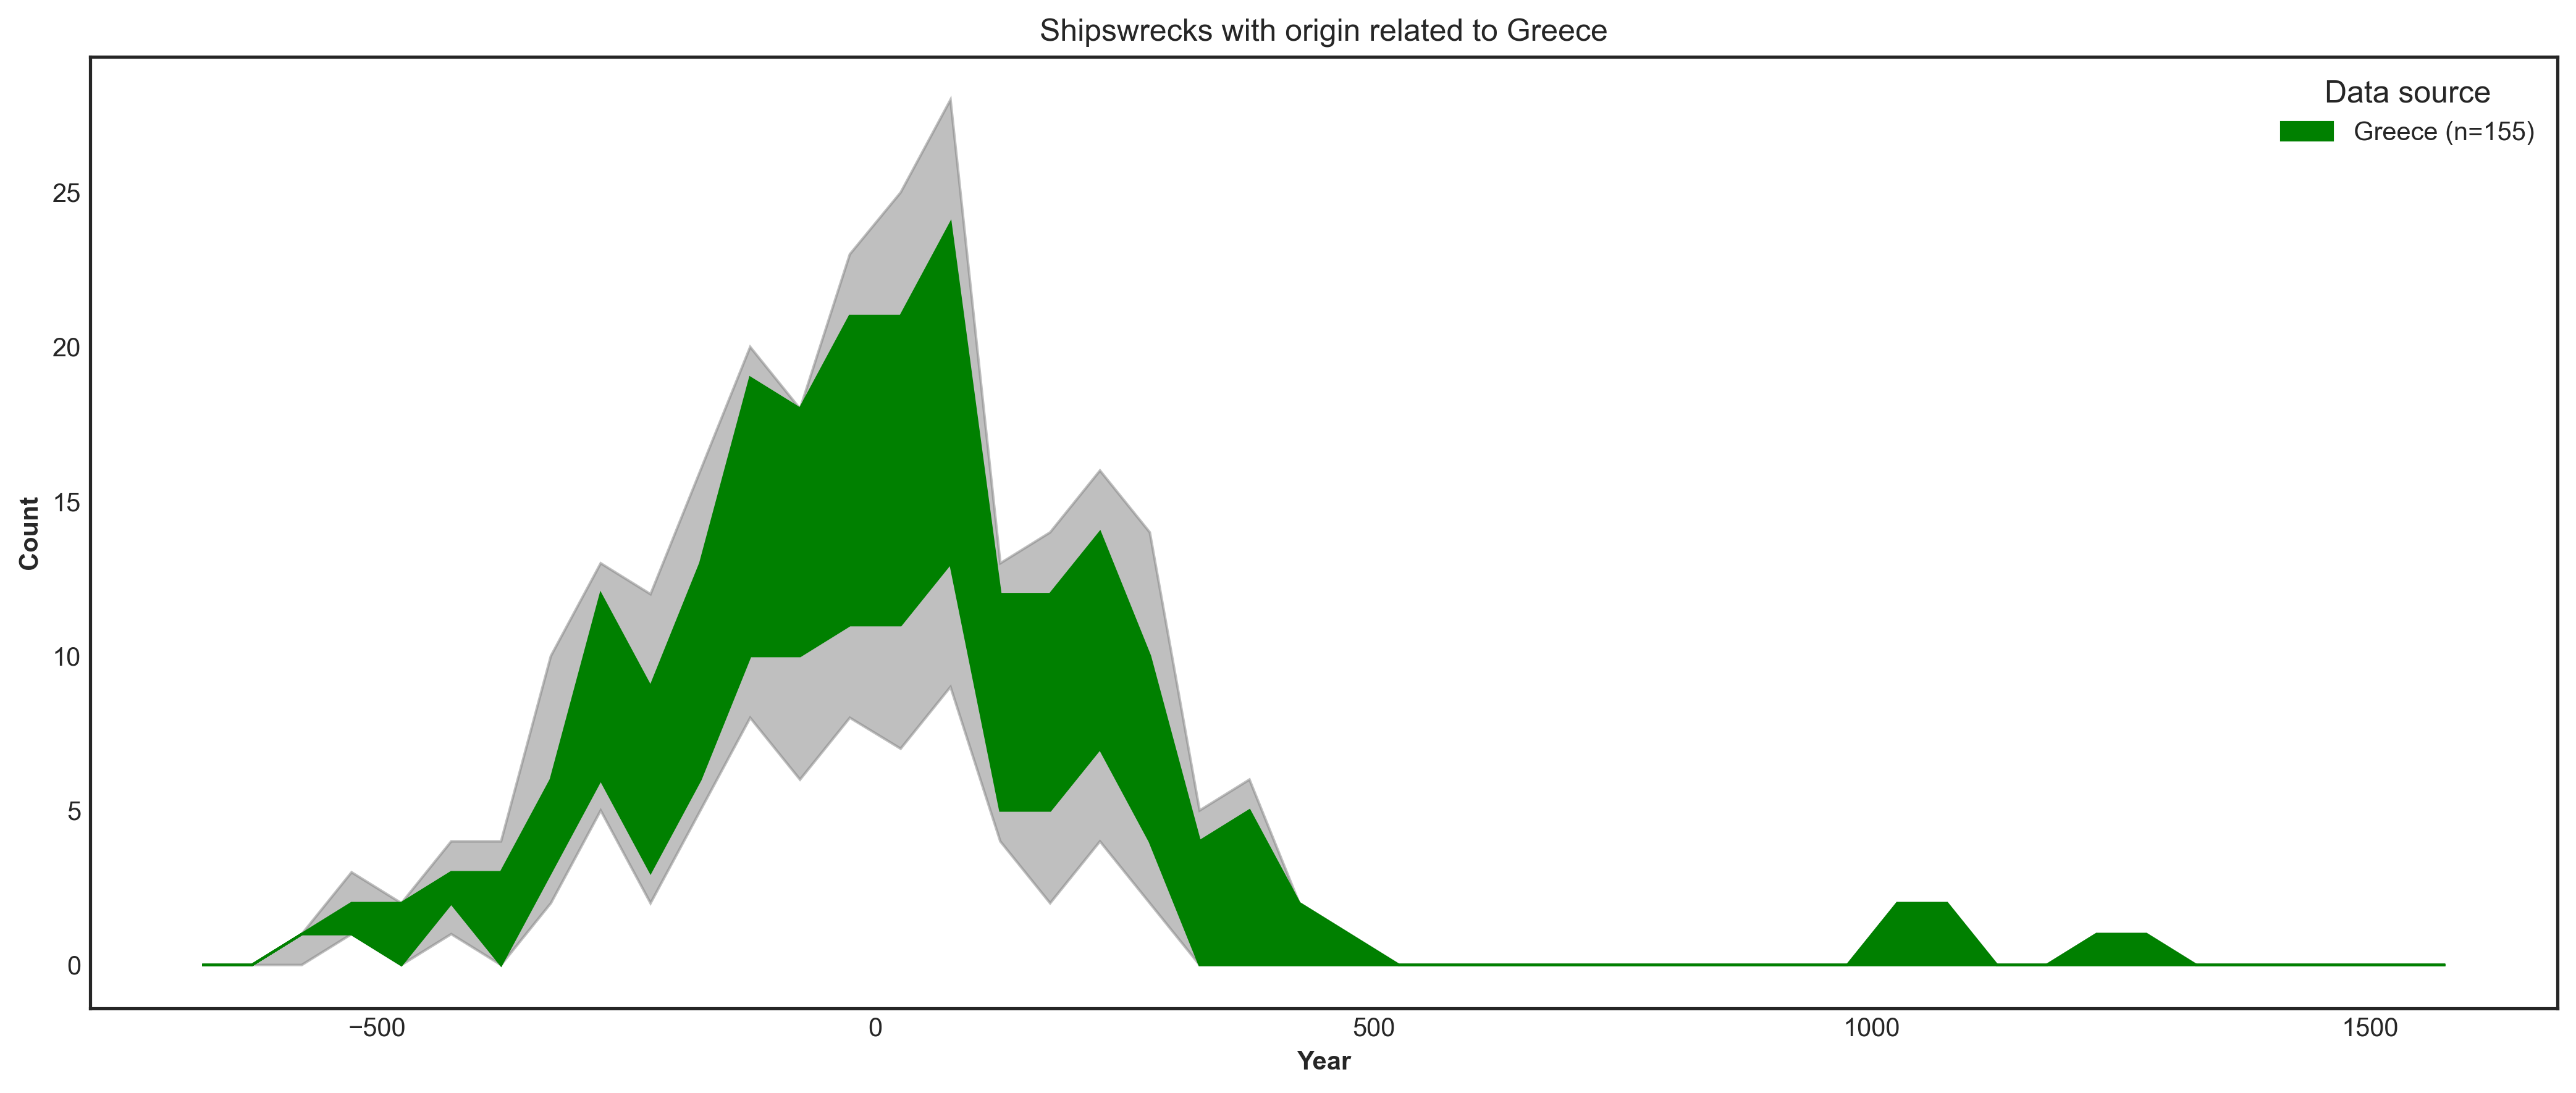

In [91]:
plt.style.use("seaborn-white")
plt.rcParams['figure.dpi'] = 300
plt.rcParams['font.size'] = 10

tab_colors_list = list(mcolors.TABLEAU_COLORS.keys())

fig, ax = plt.subplots(figsize=(14, 6), tight_layout=True)


tempun.plot_timeblocks_data(
    greece_simulation, ax=ax, color="green", label=f"Greece (n={len(greece_df)})")

    
ax.set_xlabel("Year", weight="bold")
ax.set_ylabel("Count", weight="bold")
ax.set_title("Shipswrecks with origin related to Greece")
ax.legend(title="Data source", title_fontsize="large", bbox_to_anchor=(1, 1), loc='upper right')